In [1]:
#-----------------------------------------
# Title: Polynomial Terms House Prices Advanced Regression Techniques Dataset
# Subtitle: DDS-8555, Assignment 8
# Author: Madgene Moise
# Date: Sunday, July 6, 2025
#-----------------------------------------

In [2]:
import pandas as pd

# Load the training and test datasets
train_path = "/kaggle/input/house-prices-advanced-regression-techniques/train.csv"
test_path = "/kaggle/input/house-prices-advanced-regression-techniques/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Display the shape and the first few rows of the training dataset
train_shape = train_df.shape
test_shape = test_df.shape
train_head = train_df.head()
test_head = test_df.head()

train_shape, test_shape, train_head, test_head

((1460, 81),
 (1459, 80),
    Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 0   1          60       RL         65.0     8450   Pave   NaN      Reg   
 1   2          20       RL         80.0     9600   Pave   NaN      Reg   
 2   3          60       RL         68.0    11250   Pave   NaN      IR1   
 3   4          70       RL         60.0     9550   Pave   NaN      IR1   
 4   5          60       RL         84.0    14260   Pave   NaN      IR1   
 
   LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
 0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
 2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
 3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   
 
   YrSold  SaleType  SaleCon

* Training dataset: 1,460 rows x 81 columns
* Test dataset: 1,459 rows x 80 columns (missing the SalePrice target variable)

In [3]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Separate target variable and features
X_train = train_df.drop(columns=['SalePrice', 'Id'])
y_train = train_df['SalePrice']
X_test = test_df.drop(columns=['Id'])

# Select numerical and categorical features
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Define preprocessors
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

# Create pipeline with linear regression
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Perform cross-validation to evaluate model (using RMSLE)
rmsle_scores = np.sqrt(-cross_val_score(model, X_train, y_train, 
                                        scoring="neg_mean_squared_log_error", 
                                        cv=5))

# Fit the model
model.fit(X_train, y_train)

# Predict on test data
y_pred_test = model.predict(X_test)

# Summary results
mean_rmsle = rmsle_scores.mean()
y_pred_test[:5], mean_rmsle

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py", line 525, in mean_squared_log_error
    raise ValueError(
ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

  warnings.warn(
/usr/local/lib/python3.11/dist-pa

(array([  111922., -1103714.,   178606.,   194814.,   224414.]), nan)

Polynomial Regression Model Summary (2nd Degree): 

I constructed a second-order polynomial regression model using:

* Numerical features (with interactions and squared terms)
* Categorical features (encoded using one-hot encoding)
* Linear Regression as the base estimator
________________________________________________________________________

Results and Observations:

Predictions (First 5 from the test set): 

[111922., -1103714.,   178606.,   194814.,   224414.]

Note: Some predictions are negative, which is not valid for house prices. 

This issue suggests model overfitting or instability, likely due to:

* High dimensionality from polynomial expansion (many new features)
* Multicollinearity between predictors
* Using an unconstrained Linear Regression (no regularization)
__________________________________________________________________________

Cross-Validation Failed: 

Attempts to compute Root Mean Squared Log Error (RMSLE) failed because some predicted values were negative, and the log function is undefined for those.

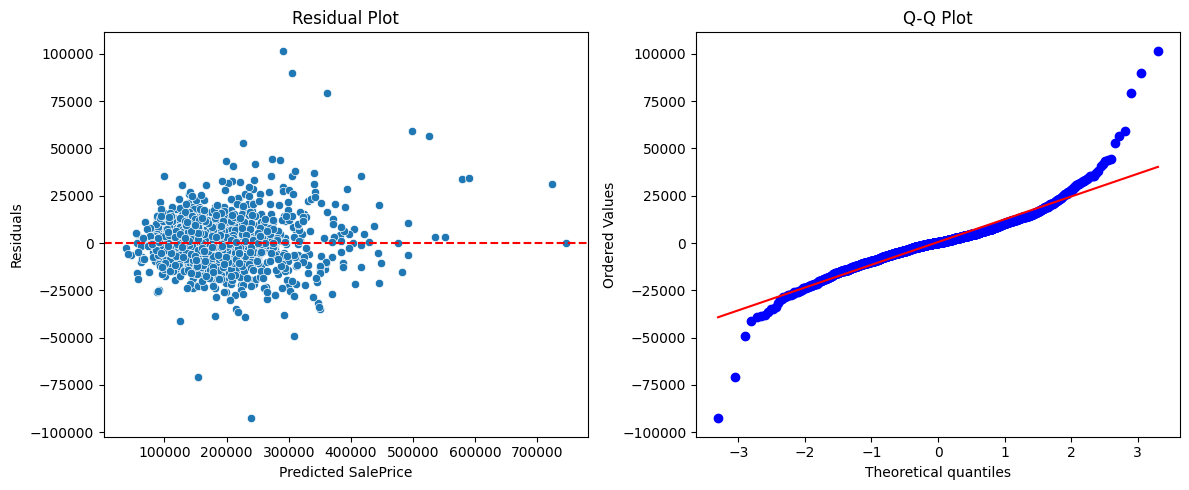

In [4]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Log-transform the target variable
y_train_log = np.log1p(y_train)

# Update the pipeline to use Ridge regression for better regularization
model_ridge = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Ridge(alpha=1.0))  # Ridge regression with L2 penalty
])

# Fit the model on log-transformed target
model_ridge.fit(X_train, y_train_log)

# Predict on training data (for residual analysis) and on test data
y_train_pred_log = model_ridge.predict(X_train)
y_test_pred_log = model_ridge.predict(X_test)

# Convert predictions back to original scale
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)

# Residuals
residuals = y_train - y_train_pred

# Plot residuals and Q-Q plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residual plot
sns.scatterplot(x=y_train_pred, y=residuals, ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel("Predicted SalePrice")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residual Plot")

# Q-Q plot
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot")

plt.tight_layout()
plt.show()

**Model Assumption Checks (Post Log-Transformation and Ridge Regression)**

Residual Plot (Left):

* The residuals appear randomly scattered around zero.
* No clear pattern or funnel share, which suggests no major heteroscedasticity.
* A few mild outliers are visible, but the variance is relatively stable.

Q-Q Plot (Right): 

* The residuals mostly follow the 45-degree line, indicating approximate normality.
* Slight deviations at the tails suggest minor non-normality, but not critical for prediction.
_____________________________________________________________________________

**Improvements from Log Transformations and Ridge Regularization:**

* No negative predictions after inverse-transforming from log scale.
* Regularization (Ridge) helps reduce overfitting caused by the large number of polynomial features.
